In [1]:
%pip install pandas numpy tensorflow[and-cuda] matplotlib scikit-learn keras-tuner ipympl
from load_data import read_data
import tensorflow as tf
import numpy as np
np.random.seed(0)
# test GPU found
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


2023-12-10 22:23:37.947504: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 22:23:37.947535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 22:23:37.948568: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 22:23:37.953740: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 22:23:38.550011: W tensorflow/compiler/tf2

Num GPUs Available:  1


2023-12-10 22:23:38.999972: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-10 22:23:39.043448: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-10 22:23:39.043646: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
# Load data
X, Y = read_data()
# # y to one-hot
Y = tf.keras.utils.to_categorical(Y, num_classes=10)
# Shuffle
shuffle_idx = np.random.permutation(len(X))
X = X[shuffle_idx]
Y = Y[shuffle_idx]
print(f"X data shape: {X.shape}")
print(f"y data shape: {Y.shape}")

X data shape: (1000, 222, 3)
y data shape: (1000, 10)


In [3]:
# Do a grid search with Keras tuner
import kerastuner as kt
from sklearn.model_selection import train_test_split

def model_builder(hp):
    """ take in a padded sequence of 3d coordinates, and output a class label
    """
    inputs = tf.keras.Input(shape=(X.shape[1],X.shape[2]))
    
    # Hyperparameters for architecture
    num_conv_layers = hp.Int('num_conv_layers', min_value=1, max_value=4, step=1)
    num_filters = hp.Int('num_filters', min_value=16, max_value=128, step=16)
    use_middle_max_pool = hp.Boolean('use_middle_max_pool')
    # Whether to use a batch normalization between each conv layer
    use_batch_norm_regularization1 = hp.Boolean('use_batch_norm_regularization1')
    
    x = inputs
    
    for i in range(num_conv_layers):
        x = tf.keras.layers.Conv1D(num_filters, 3, activation='linear')(x)
        if use_batch_norm_regularization1:
            x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        num_filters *= 2
    
    if use_middle_max_pool:
        x = tf.keras.layers.MaxPooling1D(3)(x)
    
    num_conv2_layers = hp.Int('num_conv2_layers', min_value=1, max_value=4, step=1)
    num_conv2_filters = hp.Int('num_conv2_filters', min_value=16, max_value=128, step=16)
    glob_avg_or_dense = hp.Choice('glob_avg_or_dense', values=['glob_avg', 'dense'])
    use_batch_norm_regularization2 = hp.Boolean('use_batch_norm_regularization2')
    
    for i in range(num_conv2_layers):
        x = tf.keras.layers.Conv1D(num_conv2_filters, 3, activation='linear')(x)
        if use_batch_norm_regularization2:
            x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        num_conv2_filters *= 2
    
    if glob_avg_or_dense == 'glob_avg':
        x = tf.keras.layers.GlobalAveragePooling1D()(x)
    
    else:
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.5)(x)
    
    x = tf.keras.layers.Dense(10, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, x)
    
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy']
                )
    return model

OPT_RUN_DIR = f'keras-tuner-logs_batch_size{128}_new'
tuner = kt.Hyperband(model_builder,
                        objective='val_loss',
                        max_epochs=200,
                        factor=3,
                        directory=OPT_RUN_DIR,
                        project_name='digit_recognition'
                        )

# Reserve 10% of the data for testing
X_test = X[:200]
Y_test = Y[:200]
X = X[200:]
Y = Y[200:]

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
tuner.search(X_train, y_train, epochs=200, batch_size=256, validation_data=(X_val, y_val), callbacks=[early_stop])

best_hyperparams = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hyperparams}")

best_model = tuner.get_best_models()[0]
best_model.save('best_model_new.h5')

Trial 228 Complete [00h 00m 13s]
val_loss: 0.04493344947695732

Best val_loss So Far: 0.023682022467255592
Total elapsed time: 00h 26m 00s
Best hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7f2a70248590>


/home/ilmari/python/DigitRecognition3D/.newvenv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
# Check each tuned result from keras-tuner-logs
import os
import json

# Get all the log directories
log_dirs = os.listdir(f'{OPT_RUN_DIR}/digit_recognition/')

jsons = []
val_losses = []
val_accuracies = []
# Check the accuracy and loss for each trial.json file (one in each log directory)
for log_dir in log_dirs:
    if not os.path.isdir(f'{OPT_RUN_DIR}/digit_recognition/{log_dir}'):
        continue
    with open(f'{OPT_RUN_DIR}/digit_recognition/{log_dir}/trial.json') as f:
        trial_json = json.load(f)
    try:
        acc = trial_json['metrics']["metrics"]["val_accuracy"]["observations"][0]["value"][0]
        loss = trial_json['metrics']["metrics"]["val_loss"]["observations"][0]["value"][0]
    except KeyError:
        continue
    print(acc)
    
    val_losses.append(loss)
    val_accuracies.append(acc)
    jsons.append(trial_json)

# Find the json with the lowest loss
min_loss = min(val_losses)
min_loss_idx = val_losses.index(min_loss)
print(f"Lowest loss: {min_loss}")
print(f"Params: {jsons[min_loss_idx]}")

0.32499998807907104
0.09375
0.17499999701976776
0.15625
0.17499999701976776
0.78125
0.13750000298023224
0.8812500238418579
0.3812499940395355
0.2874999940395355
0.956250011920929
0.13124999403953552
0.625
0.17499999701976776
0.5249999761581421
0.19374999403953552
0.5249999761581421
0.9937499761581421
0.14374999701976776
0.13750000298023224
0.10625000298023224
0.3499999940395355
0.18125000596046448
0.14374999701976776
0.34375
0.3062500059604645
0.10000000149011612
0.28125
0.21875
0.13750000298023224
0.21250000596046448
0.2562499940395355
0.10000000149011612
0.17499999701976776
0.15000000596046448
0.6499999761581421
0.16249999403953552
0.14374999701976776
0.13750000298023224
0.3687500059604645
0.13750000298023224
0.15000000596046448
0.34375
0.10000000149011612
0.5249999761581421
0.19374999403953552
0.3125
0.21250000596046448
0.606249988079071
0.793749988079071
0.23125000298023224
0.13124999403953552
0.18125000596046448
0.36250001192092896
0.4375
0.28125
0.7749999761581421
0.46875
0.10000

In [9]:
def get_untrained_best_model():
    return model_builder(best_hyperparams)

def get_conv_model():
    return tf.keras.models.load_model('model.h5')

In [31]:
# Train the model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import shutil
from sklearn.preprocessing import StandardScaler, MinMaxScaler

model = get_untrained_best_model()
print(model.summary())

# Combine the training and validation data, and use X_test as the test set
X_train = X
y_train = Y


print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

# Train the model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
shutil.rmtree('./tblogs_new', ignore_errors=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir='./tblogs_new', histogram_freq=1)

model.fit(X_train, y_train, epochs=200, callbacks=[early_stop, tensorboard_cb], validation_data=(X_test, Y_test))

# Evaluate the model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(Y_test, axis=1)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Confusion matrix: \n{confusion_matrix(y_test, y_pred)}")

# Save the model
model.save('model_new.h5')

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 222, 3)]          0         
                                                                 
 conv1d_80 (Conv1D)          (None, 220, 80)           800       
                                                                 
 batch_normalization_80 (Ba  (None, 220, 80)           320       
 tchNormalization)                                               
                                                                 
 re_lu_80 (ReLU)             (None, 220, 80)           0         
                                                                 
 conv1d_81 (Conv1D)          (None, 218, 160)          38560     
                                                                 
 batch_normalization_81 (Ba  (None, 218, 160)          640       
 tchNormalization)                                        

/home/ilmari/python/DigitRecognition3D/.newvenv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 87ms/step
(3, 67, 192)
(67, 2)
(67, 2)
(67, 2)


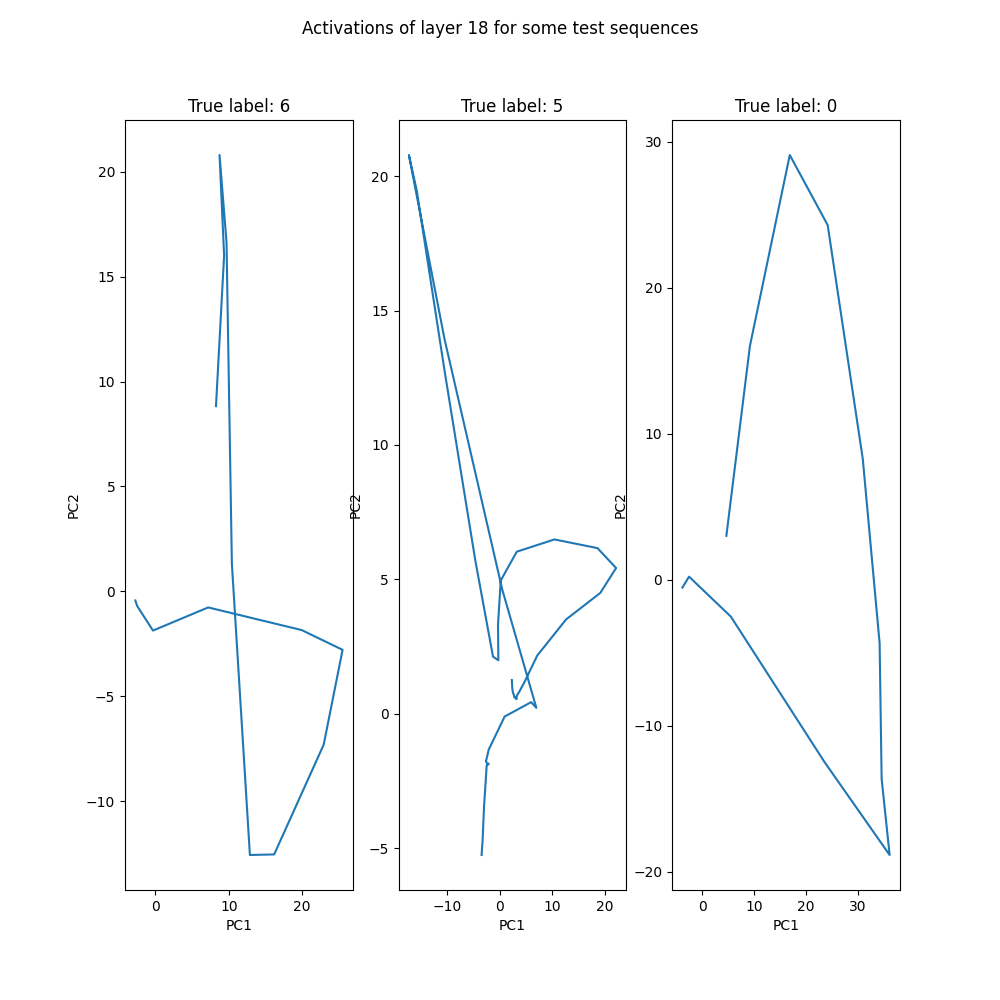

In [32]:
%matplotlib widget
# Plot the activations of the first convolutional layer
import matplotlib.pyplot as plt
import random
indices = random.choices(range(len(X_test)), k=3)

x_plot_test = X_test[indices]
true_labels = y_test[indices]

# Convolutional layers are indices 1, 3, 5, 7, 8, 11, 14, 17
layer_number = 18

model_head = tf.keras.Model(inputs=model.input, outputs=model.layers[layer_number].output)

output = model_head.predict(x_plot_test)
print(output.shape) # (n, 220, 32)

fig, ax = plt.subplots(1, len(indices), figsize=(10, 10))
from sklearn.decomposition import PCA
for seq_idx in range(len(indices)):
    #Take the sequence, and project it onto the first 2 principal components
    pca = PCA(n_components=2)
    pca.fit(output[seq_idx])

    # Project the data onto the first 2 principal components
    reduced = pca.transform(output[seq_idx])
    # average over channels
    #reduced = np.mean(output[seq_idx], axis=1)
    #reduced = output[seq_idx]
    print(reduced.shape) # (220, 2)
    

    # Plot the data
    ax[seq_idx].plot(reduced[:,0], reduced[:,1])
    ax[seq_idx].set_title(f"True label: {true_labels[seq_idx]}")
    ax[seq_idx].set_xlabel("PC1")
    ax[seq_idx].set_ylabel("PC2")
    
# Title
fig.suptitle(f"Activations of layer {layer_number} for some test sequences")
# Save figure
plt.savefig(f"layer_{layer_number}_activations.png")
plt.show()

